# Baseline Model

In [4]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [5]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/data_for_model_iterations_03.csv', sep = ',')

In [6]:
df_flight_info = data_flight_info.copy()
df_flight_info.isnull().sum()

fl_date                0
mkt_unique_carrier     0
op_unique_carrier      0
op_carrier_fl_num      0
origin                 0
dep_time               0
crs_dep_time           0
dep_delay              0
dest                   0
arr_time               0
arr_delay              0
crs_arr_time           0
actual_elapsed_time    0
crs_elapsed_time       0
distance               0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
year                   0
month                  0
day                    0
weekday                0
total_carrier_delay    0
dtype: int64

# Model Training

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

## Feature Engineered Dataset

####  with Flight Number (onehot), average_route_time, total_security_delay, total_nas_delay

In [8]:
#### Shuffling dataset so model doesn't train on pattern

In [9]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','crs_elapsed_time','crs_arr_time','distance','year','month','day','weekday']]
y = df_flight_info['arr_delay']

In [10]:
X.shape

(978886, 8)

In [11]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [12]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 685220, number of used features: 8
[LightGBM] [Info] Start training from score 5.269629
Model RMSE is:  43.05947022125832
Model R2 Score is:  0.035848224981133936


[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 685220, number of used features: 8
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Info] Start training from score 5.269629
Training until validation scores don't 

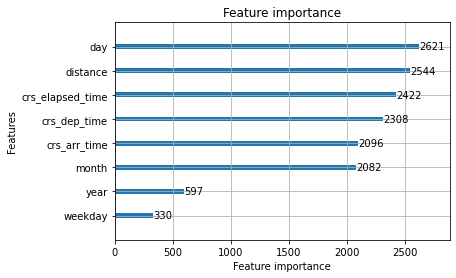

In [13]:
from lightgbm import plot_importance
import matplotlib.pyplot  as plt



params = {
    'booster': 'rf',
    'objective': 'regression',
    'num_leaves': 31,
    'subsample': 0.8,
    'bagging_freq': 1,
    'feature_fraction ': 0.8,
    'slient': 1,
    'learning_rate ': 0.01,
    'seed': 0
}


# Construct training set
dtrain = lgb.Dataset(X_train,y_train)
dtest = lgb.Dataset(X_test,y_test)
num_rounds = 500
# xgboost model training
model = lgb.train(params,dtrain, num_rounds, valid_sets=[dtrain, dtest], 
                  verbose_eval=100, early_stopping_rounds=100)

# Make predictions on the test set
y_pred = model.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))

# Show important features
plot_importance(model)
plt.show()

##### XGBoost

In [14]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  43.62778174781895
Model R2 Score is:  0.01022995837073526


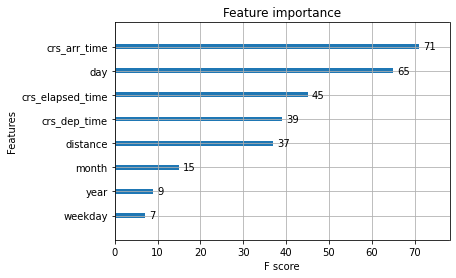

In [15]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

##### Ridge Regression

In [16]:
# ss = StandardScaler()
# X_scaled = ss.fit_transform(X)
# # Split dataset into training set and test set
# X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.3) # 70% training and 30% test

In [17]:
# ridgereg = Ridge(alpha=0.001,normalize=True)
# poly = PolynomialFeatures(degree = 3)
# X_ = poly.fit_transform(X_test_scaled)
# results = ridgereg.fit(X_train_scaled,y_train_scaled)
# y_pred_scaled = results.predict(X_test_scaled)

In [18]:
# print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled)))
# print('Model R2 Score is: ',r2_score(y_test_scaled,y_pred_scaled))

##### Random Forest

In [19]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators=100)

In [20]:
#Train the model using the training sets 
clf.fit(X_train,y_train)

RandomForestRegressor()

In [21]:
y_pred=clf.predict(X_test)

In [22]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))

Model RMSE is:  44.296988970266796
Model R2 Score is:  -0.020367116177496092
